# Compare models with ARGO

This notebook shows an example of how to;
* load ARGO data using the `pqtool.drivers` package
* apply filters from the `pqtool.filters` package
* load NEMO model data using the driver
* interpolate the model data to the ARGO location using `xarray`
* calculate metrics grouped by depth layer
* visualise the results using `matplotlib`

In [1]:
import intake
import xarray as xr
import numpy as np

cat = intake.open_catalog('catalog.yaml')

list(cat)

['argo', 'sst', 'reanalysis', 'operational']

In [2]:
dates = slice('2015-01-01', '2015-01-31')

argo = cat['argo'].subset(date=dates).read()
argo = argo.where((argo['pressure_qc'] == 1) &
                  (argo['time_qc'] == 1) &
                  (argo['temperature_qc'] == 1) &
                  (argo['salinity_qc'] == 1)).dropna(dim='obs')
argo = argo.get(['temperature', 'salinity', 'dc_reference'])

print('Number of observations: %d' % argo.sizes['obs'])

Number of observations: 23863


In [3]:
from pqtool.filters.argo import rolling_average, keep_closest

bsfs_levels = np.array([2.5010786, 7.5111933, 12.536196, 17.583405, 
                        22.663736, 27.793465, 32.996857, 38.310074, 
                        43.786976, 49.50773, 55.591507, 62.215195, 
                        69.64064, 78.25402, 88.6217, 101.56744, 
                        118.27473, 140.41339, 170.27762, 210.89946, 
                        266.06668, 340.13943, 437.56604, 562.0992, 
                        715.91516, 899.0139, 1109.2192, 1342.7784, 
                        1595.243, 1862.2532, 2140.0208])

# Apply the 1m rolling average for noisy ARGO
argo = argo.groupby('dc_reference').map(rolling_average, delta=0.5)

# Retain only levels closest to the model levels
argo = argo.groupby('dc_reference').map(keep_closest, levels=bsfs_levels).dropna('obs')

print('Number of observations: %d' % argo.sizes['obs'])

Number of observations: 1750


In [4]:
experiments = ['operational', 'reanalysis']

models = []
for exp in experiments:
    nemo = cat[exp].subset(date=dates).read()
    nemo = nemo.chunk({'time': nemo['time'].size})  # Disable chunking along time for interp()
    
    model = nemo.interp(**argo.coords, method='nearest').load()
    model = model.where(model['salinity'] != 0)  # Drop salinity == 0 values (outside grid)
    model = model.rename({'temperature': 'model_temperature',
                          'salinity': 'model_salinity'})
    model.coords['model'] = xr.DataArray(np.array([exp]), dims='model')

    models.append(model)
    nemo.close()

models = xr.concat(models, dim='model')
combined = argo.merge(models).dropna('obs')
combined.attrs = {}  # Clear dataset attributes copied along from the original ARGO file

combined

<xarray.Dataset>
Dimensions:            (model: 2, obs: 1626)
Coordinates:
    time               (obs) datetime64[ns] 2015-01-02T18:03:46 ... 2015-01-30T03:32:00
    latitude           (obs) float32 43.819 43.819 43.819 ... 41.60376 41.60376
    longitude          (obs) float32 31.862 31.862 31.862 ... 29.97081 29.97081
    depth              (obs) float64 5.357 10.32 20.33 ... 1.361e+03 1.607e+03
  * model              (model) object 'operational' 'reanalysis'
Dimensions without coordinates: obs
Data variables:
    temperature        (obs) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    salinity           (obs) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dc_reference       (obs) object dask.array<chunksize=(138,), meta=np.ndarray>
    model_temperature  (model, obs) float32 9.612727 9.618422 ... 8.993511
    model_salinity     (model, obs) float32 18.201479 18.201887 ... 22.328905

In [5]:
bins = np.array([2, 5, 10, 20, 30, 50, 75, 100, 200, 500, 1000])

def metrics(data):
    result = xr.Dataset()
    
    for name, var in data.variables.items():
        if not name.startswith('model_') and 'model_%s' % name in data.variables:
            bias = data['model_%s' % name] - var
            result['%s_bias' % name] = bias.mean(dim='obs')
            result['%s_rmse' % name] = xr.ufuncs.sqrt((bias ** 2.).mean(dim='obs'))
            result['%s_nobs' % name] = bias.count(dim='obs')

    return result

result = combined.groupby_bins('depth', bins=bins).apply(metrics)
result.rename_vars({'salinity_nobs': 'nobs'}).drop_vars('temperature_nobs').to_dataframe()

temperature_bias  temperature_rmse  salinity_bias  \
depth_bins  model                                                            
(2, 5]      operational         -0.369128          0.477103      -0.011712   
            reanalysis          -0.225348          0.276590      -0.069872   
(5, 10]     operational         -0.177990          0.575305       0.017483   
            reanalysis          -0.075314          0.405731      -0.013541   
(10, 20]    operational         -0.150727          0.470032       0.013692   
            reanalysis          -0.094223          0.398234      -0.026818   
(20, 30]    operational         -0.106724          0.465591       0.013280   
            reanalysis          -0.071132          0.414132      -0.036672   
(30, 50]    operational         -0.032490          0.512766       0.064358   
            reanalysis           0.056763          0.467000       0.036894   
(50, 75]    operational          0.054464          0.662556       0.033329   
            reanalysis           0.067724          0.545446       0.029218   
(75, 100]   operational         -0.041692          0.346676       0.011872   
            reanalysis          -0.058078          0.332515       0.025862   
(100, 200]  operational         -0.014032          0.105572      -0.007119   
            reanalysis          -0.023225          0.091720       0.008514   
(200, 500]  operational         -0.004177          0.040878      -0.020029   
            reanalysis          -0.035605          0.040389       0.006465   
(500, 1000] operational         -0.006051          0.017899       0.002706   
            reanalysis          -0.000101          0.015230       0.008829   

                         salinity_rmse  nobs  
depth_bins  model                             
(2, 5]      operational       0.094133     2  
            reanalysis        0.077341     2  
(5, 10]     operational       0.282191    36  
            reanalysis        0.143137    36  
(10, 20]    operational       0.243228   129  
            reanalysis        0.145268   129  
(20, 30]    operational       0.232686   133  
            reanalysis        0.137530   133  
(30, 50]    operational       0.267843   268  
            reanalysis        0.198058   268  
(50, 75]    operational       0.417453   213  
            reanalysis        0.336402   213  
(75, 100]   operational       0.426080   152  
            reanalysis        0.345700   152  
(100, 200]  operational       0.284865   270  
            reanalysis        0.231774   270  
(200, 500]  operational       0.085575   252  
            reanalysis        0.044612   252  
(500, 1000] operational       0.020586   126  
            reanalysis        0.024394   126

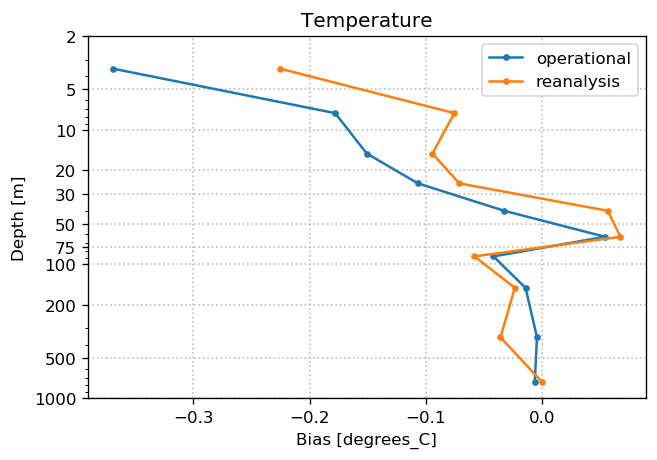

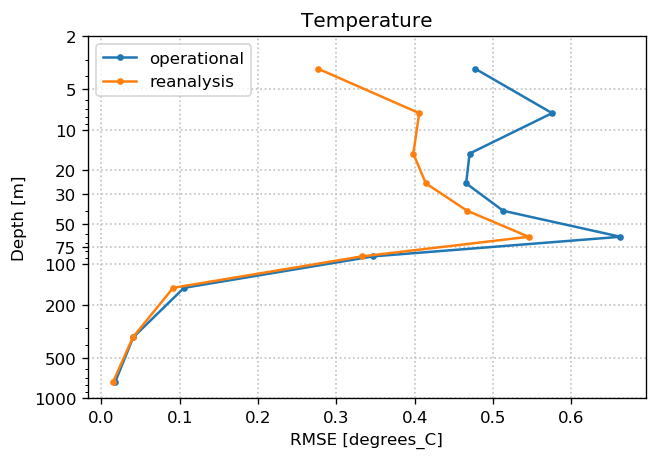

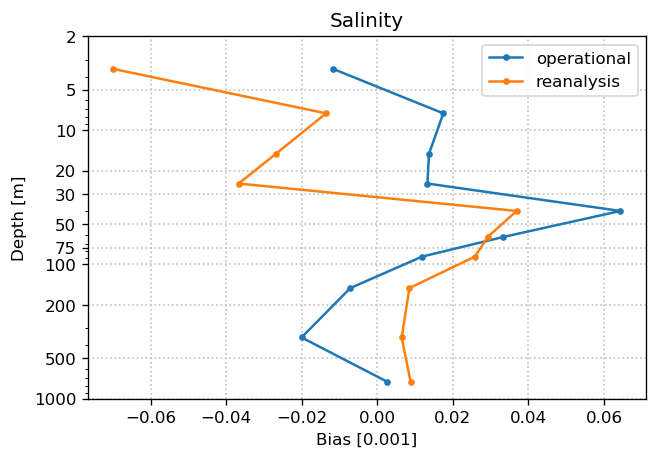

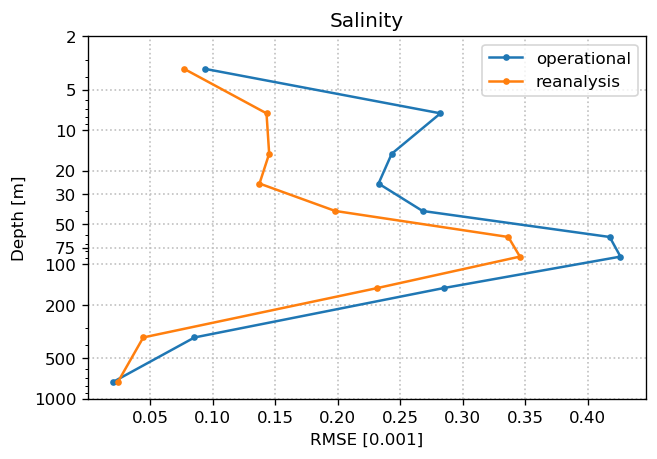

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

for variable in ['temperature', 'salinity']:
    for metric in ['Bias', 'RMSE']:
        fig = plt.figure(dpi=120)
        ax = plt.axes()

        result['depth'] = xr.DataArray((bins[1:] + bins[:-1])/ 2., dims='depth_bins')
        for model in result['%s_%s' % (variable, metric.lower())].transpose('model', 'depth_bins'):
            plt.plot(model, result['depth'], '.-', label=model['model'].data)

        plt.semilogy()
        ax.invert_yaxis()
        ax.set_yticks(bins)
        ax.set_yticklabels(bins)

        plt.title(variable.capitalize())
        plt.xlabel('%s [%s]' % (metric, combined[variable].attrs['units']))
        plt.ylabel('Depth [m]')
        plt.legend(loc='best')
        plt.grid(True, c='silver', lw=1, ls=':')
        
        plt.savefig('%s_%s.pdf' % (variable, metric.lower()))

plt.show()